In [16]:
from misc import *
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm 

In [27]:
periods = 40
ppp = 500
states, covs, signals, [A, dt, C, D] = load_data(get_def_path()+"{}periods/{}ppp/".format(periods,ppp))
xi = lambda cov: np.dot(cov, ct(C)) + ct(D)


In [49]:
symplectic = np.array([[0,1],[-1,0]])
e = np.pi/10
parameters = np.arange(0,4*np.pi + e,e)
predictions, Sstates = {t:[] for t in range(len(parameters))},{t:[[states[0], covs[0]]] for t in range(len(parameters))}

give_pred = lambda state: np.dot(C,state)*dt
def evolve_state(Sstates, AA, dy):
    x, cov = Sstates
    XiCov = xi(cov)
    dx = np.dot(AA - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(AA,cov) + np.dot(cov, ct(AA)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    return [x + dx, cov + dcov]

In [50]:
for dy in tqdm(signals):
    for i in range(len(parameters)):
        predictions[i].append(give_pred(Sstates[i][-1][0]))
        Sstates[i].append(evolve_state(Sstates[i][-1], parameters[i]*symplectic, dy))


100%|██████████| 19999/19999 [00:26<00:00, 750.68it/s]


In [51]:
landscape = {}
cut_series = np.logspace(2,np.log10(len(signals)),20)
for length_series in tqdm(cut_series):
    losses = []
    length_series = int(length_series)
    sigs = signals[:length_series]

    for i in range(len(parameters)):
        preds = np.array(predictions[i])[:length_series]
        losses.append(np.sum(np.square(preds - sigs))/(2*dt*length_series))
    
    landscape[length_series] = losses


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Text(0, 0.5, '$C(\\omega, \\tilde{\\omega})$')

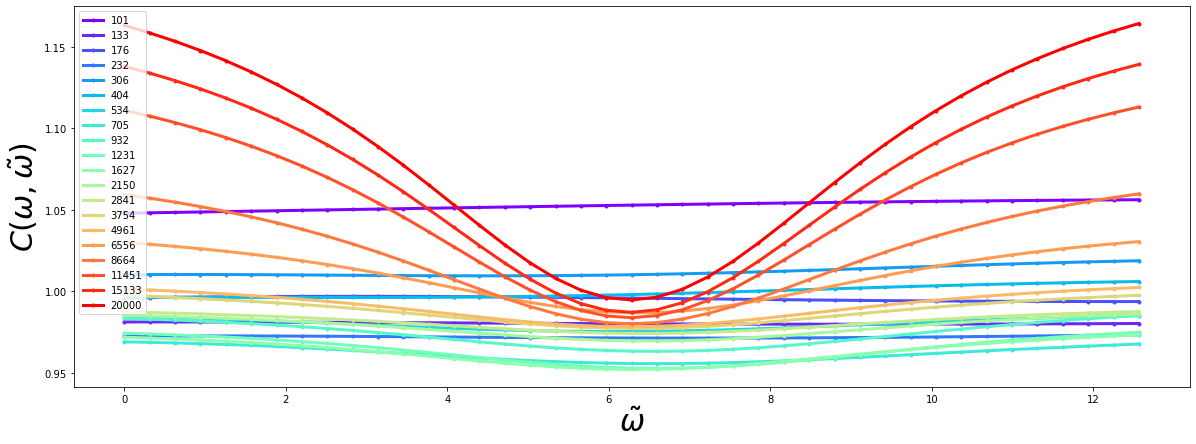

In [59]:
plt.figure(figsize=(20,7))
colors = plt.get_cmap("rainbow")
ax = plt.subplot2grid((1,1),(0,0))
for ind,p in enumerate(landscape.values()):
    plt.plot(parameters,p, color=colors(np.linspace(0,1,len(landscape)))[ind], marker='.', label="{}".format(int(np.round(cut_series[ind]+1,0))),linewidth=3)
plt.legend()
plt.xlabel(r'$\tilde{\omega}$',size=30)
plt.ylabel(r'$C(\omega, \tilde{\omega})$',size=30)